# Final Portfolio Project 2026: Regression Task

## 1. Dataset Description

### **Dataset Name**: Wine Review Dataset

### **Source & Creator**
- **Creator**: The dataset was scraped from **WineEnthusiast** (winemag.com) during the week of June 15th, 2017.
- **Source**: Accessed from Kaggle: [Wine Reviews](https://www.kaggle.com/datasets/zynicide/wine-reviews).

### **UNSDG Alignment**
This project aligns with **UNSDG Goal 12: Responsible Consumption and Production**. By analyzing wine quality and pricing, producers can optimize their production to focus on high-quality outputs rather than mass production, reducing waste and ensuring economic sustainability. Consumers can also make informed decisions, supporting fair pricing practices.

### **Features**
- `country`: The country that the wine is from.
- `description`: A few sentences from a sommelier describing the wine's taste, smell, look, feel, etc.
- `designation`: The vineyard within the winery where the grapes that made the wine are from.
- `points`: The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they only post reviews for wines that score >=80).
- `price`: The cost for a bottle of the wine.
- `province`: The province or state that the wine is from.
- `region_1`: The wine growing area in a province or state (ie Napa).
- `region_2`: Sometimes there are more specific regions specified within a wine growing area (ie Rutherford within Napa Valley), but this value can sometimes be blank.
- `taster_name`: Name of the person who tasted and reviewed the wine.
- `taster_twitter_handle`: Twitter handle for the person who tasted and reviewed the wine.
- `title`: The title of the wine review, which often contains the vintage if you're interested in extracting that feature.
- `variety`: The type of grapes used to make the wine (ie Pinot Noir).
- `winery`: The winery that made the wine.

### **Research Questions**
1. **Price Prediction**: Can we accurately predict the price of a wine based on its quality rating (points), variety, and origin?
2. **Quality vs. Price**: Is there a significant linear relationship between the price of a wine and its rating points?
3. **Regional Influence**: How does the country or province of origin affect the pricing of the wine?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV , cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

# Set plot style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [ ]:
from google.colab import files
import pandas as pd

uploaded = files.upload()

Saving winemag-data-130k-v2.csv to winemag-data-130k-v2.csv


In [ ]:
# Load Dataset
try:
    df = pd.read_csv('winemag-data-130k-v2.csv', index_col=0)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: File not found. Please ensure 'winemag-data-130k-v2.csv' is in the notebook directory.")

# Initial Inspect
df.head()

Dataset loaded successfully.


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## 2. Data Cleaning & Preprocessing

In this section, we will:
1. Check for and handle missing values.
2. Remove duplicate entries.
3. Detect and handle outliers.
4. Encode categorical variables.
5. Scale numerical features.

In [ ]:
# Check info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


In [ ]:
# Check missing values
print("Missing Values before cleaning:")
print(df.isnull().sum())


Missing Values before cleaning:
country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64


In [ ]:
# Handing Missing Values
# Price and Country are critical. We will drop rows where they are missing.
df = df.dropna(subset=['price', 'country', 'points', 'variety'])

# Region_2 has too many missing values, dropping column.
df = df.drop(columns=['region_2', 'taster_twitter_handle'])

# Handle duplicates
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicates removed: {duplicates}")
df = df.drop_duplicates()

print("\nRemaining missing values:")
print(df.isnull().sum())


Number of duplicates removed: 9378

Remaining missing values:
country            0
description        0
designation    32049
points             0
price              0
province           0
region_1       17957
taster_name    23272
title              0
variety            0
winery             0
dtype: int64


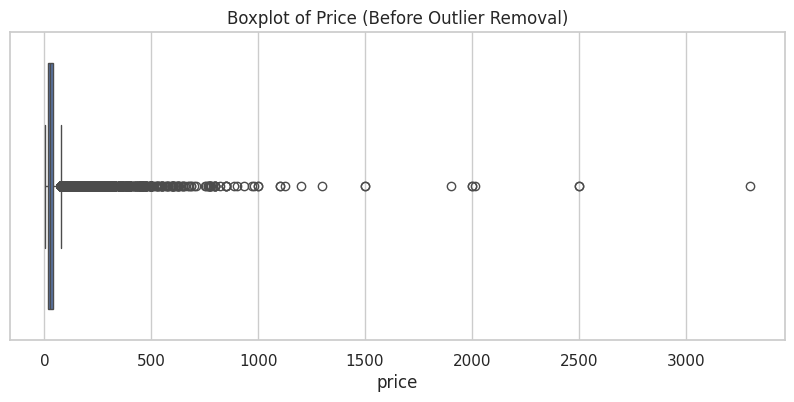

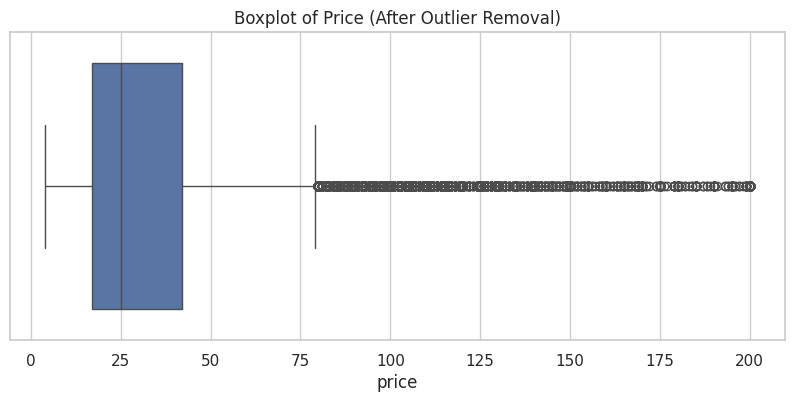

In [ ]:
# Handling Outliers in Price
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['price'])
plt.title('Boxplot of Price (Before Outlier Removal)')
plt.show()

# Removing wines priced over $200 (extreme outliers) to improve model generalization for typical wines
df = df[df['price'] <= 200]

plt.figure(figsize=(10, 4))
sns.boxplot(x=df['price'])
plt.title('Boxplot of Price (After Outlier Removal)')
plt.show()

In [ ]:
# Encoding Categorical Variables
# We will use LabelEncoder for Country, Province, and Variety as they have many categories.

le_country = LabelEncoder()
le_province = LabelEncoder()
le_variety = LabelEncoder()

df['country_encoded'] = le_country.fit_transform(df['country'])
df['province_encoded'] = le_province.fit_transform(df['province'])
df['variety_encoded'] = le_variety.fit_transform(df['variety'])

print("Encoding complete.")

Encoding complete.


## 3. Exploratory Data Analysis (EDA)

We will visualize the data to uncover patterns and relationships.

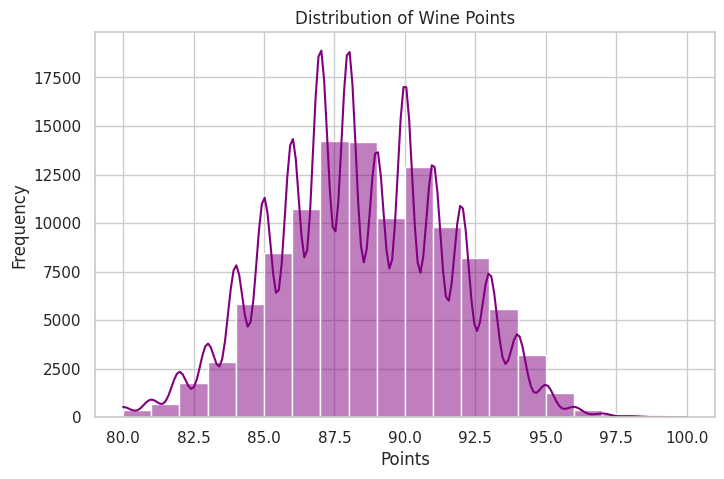

In [ ]:
# 1. Distribution of Points
plt.figure(figsize=(8, 5))
sns.histplot(df['points'], bins=20, kde=True, color='purple')
plt.title('Distribution of Wine Points')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.show()

**Insight**: The points distribution is roughly normal but slightly skewed, centered around 88-90 points.

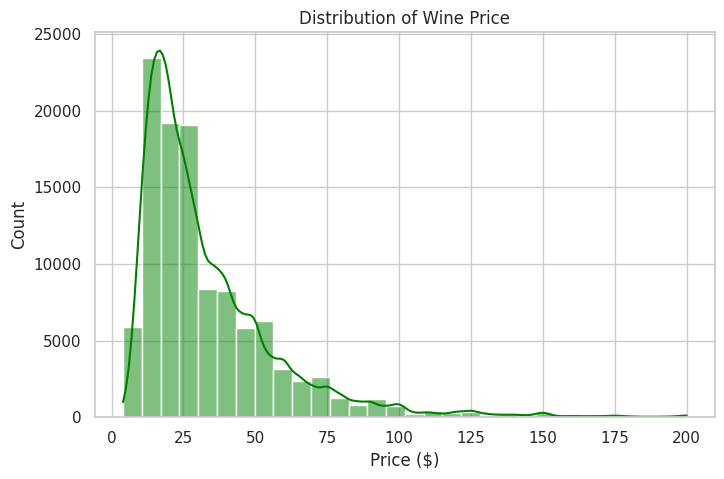

In [ ]:
# 2. Distribution of Price
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], bins=30, kde=True, color='green')
plt.title('Distribution of Wine Price')
plt.xlabel('Price ($)')
plt.show()

**Insight**: Price is heavily right-skewed, with most wines costing under $50. High-end wines are rarer.

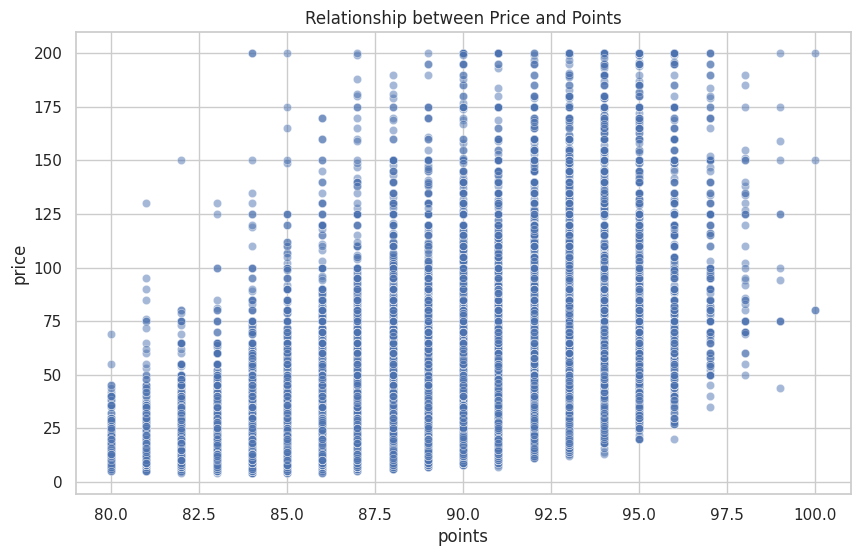

In [ ]:
# 3. Price vs Points Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='points', y='price', data=df, alpha=0.5)
plt.title('Relationship between Price and Points')
plt.show()

**Insight**: There is a positive correlation between points and price. Higher-rated wines tend to be more expensive, though there is variance.

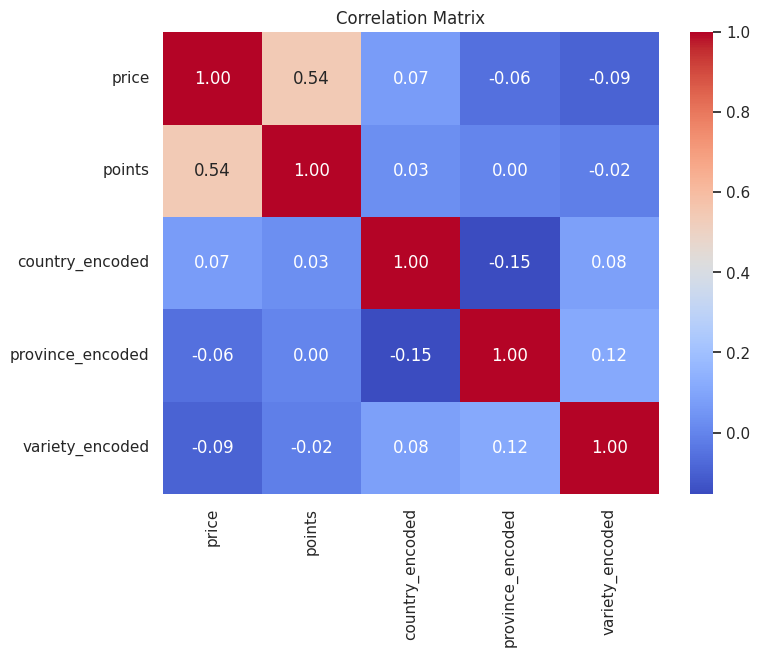

In [ ]:
# 4. Correlation Heatmap
plt.figure(figsize=(8, 6))
corr = df[['price', 'points', 'country_encoded', 'province_encoded', 'variety_encoded']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

**Insight**: Price and Points have the strongest positive correlation (approx 0.4-0.5).

/tmp/ipython-input-2939162053.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')


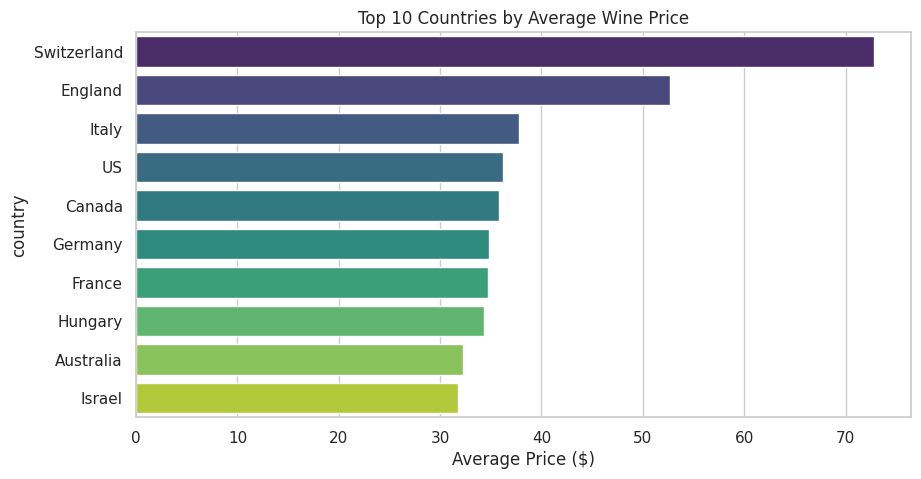

In [ ]:
# 5. Top 10 Countries by Mean Price
top_countries = df.groupby('country')['price'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')
plt.title('Top 10 Countries by Average Wine Price')
plt.xlabel('Average Price ($)')
plt.show()

**Insight**: Some countries like Switzerland or England may have higher average prices due to scarcity or import costs.

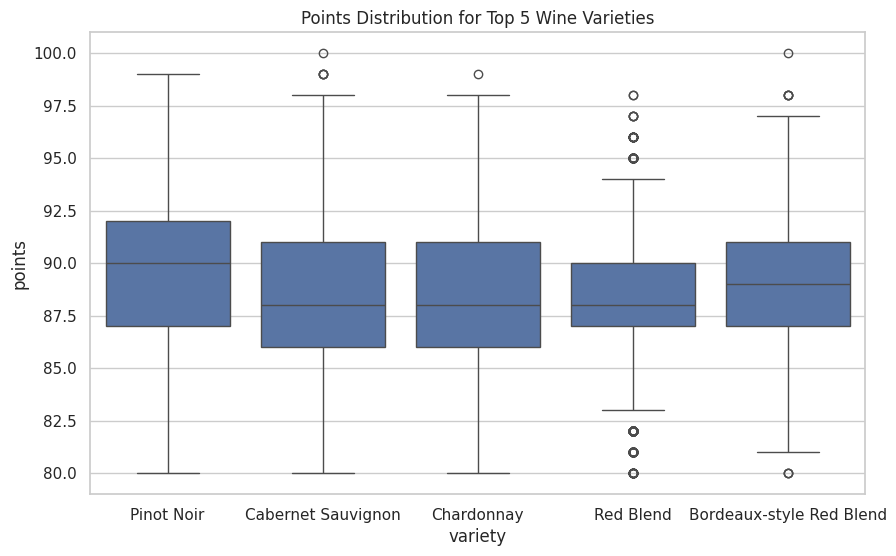

In [ ]:
# 6. Points Boxplot by Top Varieties
top_varieties = df['variety'].value_counts().head(5).index
plt.figure(figsize=(10, 6))
sns.boxplot(x='variety', y='points', data=df[df['variety'].isin(top_varieties)])
plt.title('Points Distribution for Top 5 Wine Varieties')
plt.show()

**Insight**: Different varieties (e.g., Pinot Noir, Chardonnay) align similarly in points, but some have wider ranges.

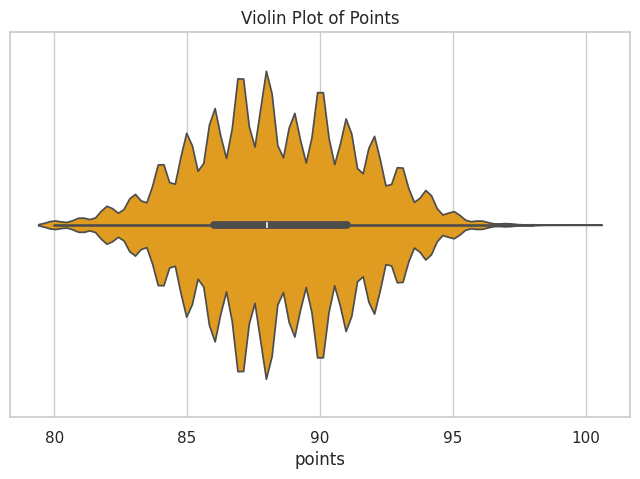

In [ ]:
# 7. Violin Plot of Points
plt.figure(figsize=(8, 5))
sns.violinplot(x=df['points'], color='orange')
plt.title('Violin Plot of Points')
plt.show()

**Insight**: This emphasizes the density around 88-90 points.

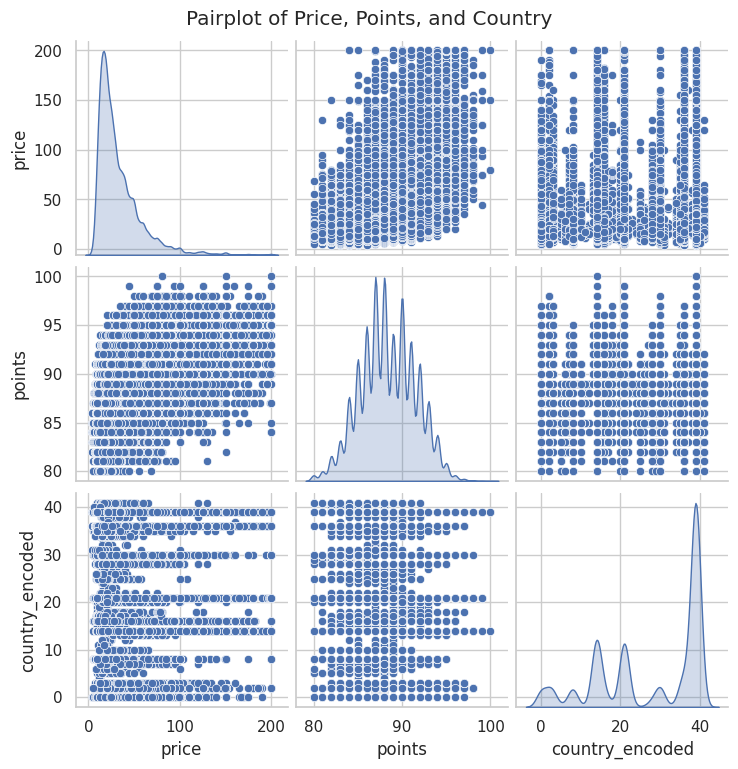

In [ ]:
# 8. Pairplot (Subset of numeric features)
sns.pairplot(df[['price', 'points', 'country_encoded']], diag_kind='kde')
plt.suptitle('Pairplot of Price, Points, and Country', y=1.02)
plt.show()

**Insight**: Shows the relationships and distributions between our key predictors and target.

## 4. Build Regression Models

Target Variable: **Price**
Features: **Points, Country, Province, Variety**

In [ ]:
# Define Features (X) and Target (y)
X = df[['points', 'country_encoded', 'province_encoded', 'variety_encoded']]
y = df['price']

# Scaling Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("Training Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)

Training Set Shape: (88697, 4)
Test Set Shape: (22175, 4)


In [ ]:
# Evaluation Function
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"--- {model_name} ---")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.4f}")
    return r2

In [ ]:
# 1. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
evaluate_model(lr, X_test, y_test, "Linear Regression")

--- Linear Regression ---
MAE: 14.43
MSE: 449.83
RMSE: 21.21
R2 Score: 0.3020


0.3019528403561199

In [ ]:
# 2. Random Forest Regressor (Classical)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test, "Random Forest Regressor")

--- Random Forest Regressor ---
MAE: 11.33
MSE: 320.30
RMSE: 17.90
R2 Score: 0.5030


0.502953539907746

In [ ]:
# 3. MLPRegressor (Neural Network)
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
evaluate_model(mlp, X_test, y_test, "MLP Regressor")

--- MLP Regressor ---
MAE: 12.60
MSE: 338.30
RMSE: 18.39
R2 Score: 0.4750


0.47501797535770096

## 5. Hyperparameter Tuning

We will tune the classical models using GridSearchCV.

In [ ]:
# Tuning Random Forest
# Using RandomizedSearchCV to save time, as RF is computationally expensive
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

rf_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), rf_params, n_iter=5, cv=3, random_state=42, n_jobs=-1)
rf_search.fit(X_train, y_train)

print("Best RF Params:", rf_search.best_params_)
print("Best RF Score:", rf_search.best_score_)

Best RF Params: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': None}
Best RF Score: 0.5027686505147642


In [ ]:
# Tuning Linear Regression (using Ridge for regularization parameter tuning)
ridge_params = {'alpha': [0.1, 1.0, 10.0]}
ridge_search = GridSearchCV(Ridge(), ridge_params, cv=3)
ridge_search.fit(X_train, y_train)

print("Best Ridge Params:", ridge_search.best_params_)
print("Best Ridge Score:", ridge_search.best_score_)

Best Ridge Params: {'alpha': 10.0}
Best Ridge Score: 0.30724389828263066


## 6. Feature Selection

We will use SelectKBest to find the most influential features.

In [ ]:
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_train, y_train)

# Get scores
scores = pd.DataFrame({'Feature': X.columns, 'Score': selector.scores_})
print(scores.sort_values(by='Score', ascending=False))

            Feature         Score
0            points  37035.133308
3   variety_encoded    769.042127
1   country_encoded    475.339327
2  province_encoded    307.388621


**Insight**: 'Points' is usually the strongest predictor of price, which makes sense.

## 7. Final Models & Comparison

In [ ]:
# Rebuilding models with best parameters (and all features, as they were all relevant)

# Final RF
final_rf = rf_search.best_estimator_
final_rf.fit(X_train, y_train)
rf_r2 = evaluate_model(final_rf, X_test, y_test, "Final Random Forest")

# Final Linear Model (Ridge)
final_ridge = ridge_search.best_estimator_
final_ridge.fit(X_train, y_train)
ridge_r2 = evaluate_model(final_ridge, X_test, y_test, "Final Ridge Regression")

# 1. Calculate Cross-Validation Scores (R2)
rf_cv_score = cross_val_score(final_rf, X_train, y_train, cv=5, scoring='r2').mean()
ridge_cv_score = cross_val_score(final_ridge, X_train, y_train, cv=5, scoring='r2').mean()

# 2. Define Features Used
features_used = "All (Points, Country, Province, Variety)"

# 3. Create Comparison Table
results = pd.DataFrame({
    'Model': ['Random Forest', 'Ridge Regression'],
    'Test R2': [rf_r2, ridge_r2],
    'CV R2 (Mean)': [rf_cv_score, ridge_cv_score],
    'Features Used': [features_used, features_used],
    'Best Params': [str(rf_search.best_params_), str(ridge_search.best_params_)]
})

print("Final Model Comparison:")
print(results)

--- Final Random Forest ---
MAE: 11.29
MSE: 316.75
RMSE: 17.80
R2 Score: 0.5085
--- Final Ridge Regression ---
MAE: 14.43
MSE: 449.83
RMSE: 21.21
R2 Score: 0.3020
Final Model Comparison:
              Model   Test R2  CV R2 (Mean)  \
0     Random Forest  0.508465      0.508722   
1  Ridge Regression  0.301952      0.307259   

                              Features Used  \
0  All (Points, Country, Province, Variety)   
1  All (Points, Country, Province, Variety)   

                                         Best Params  
0  {'n_estimators': 100, 'min_samples_split': 5, ...  
1                                    {'alpha': 10.0}  


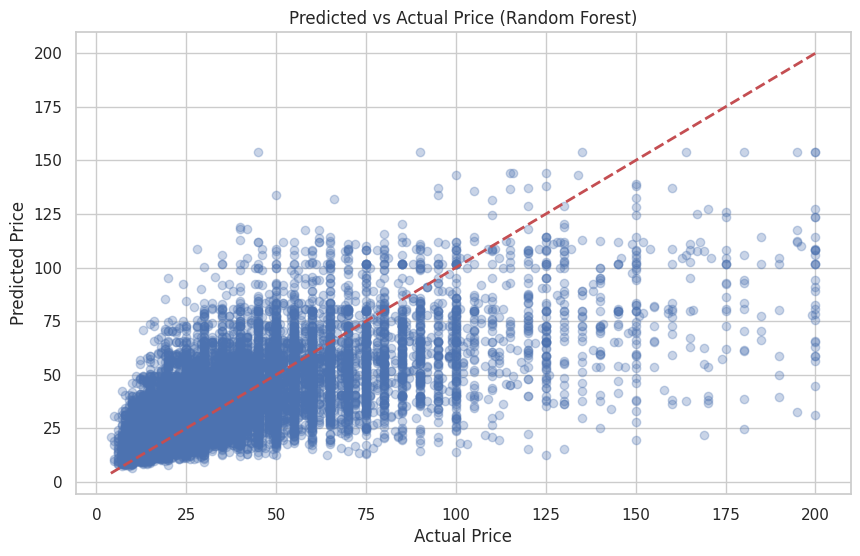

In [ ]:
# Predicted vs Actual Plot (Random Forest)
y_pred_rf = final_rf.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Price (Random Forest)')
plt.show()

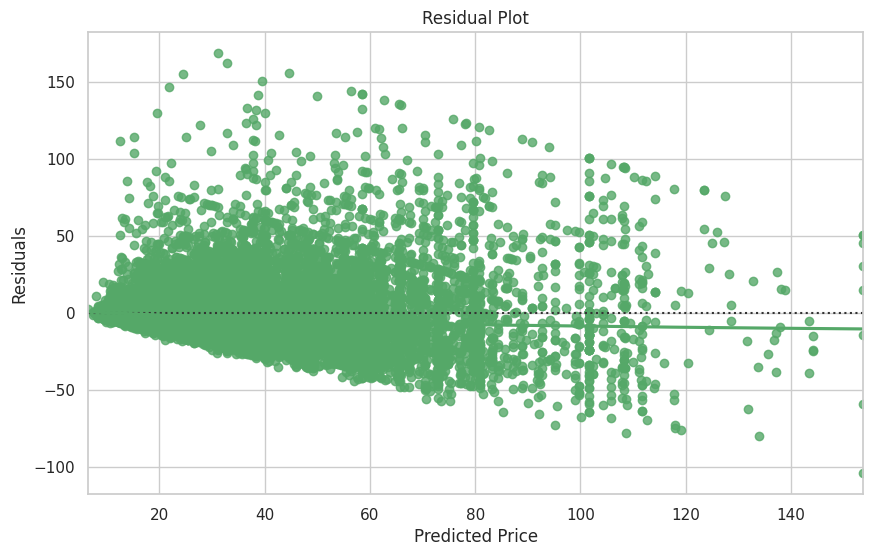

In [ ]:
# Residual Plot
residuals = y_test - y_pred_rf
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred_rf, y=residuals, lowess=True, color="g")
plt.title('Residual Plot')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.show()

## 8. Conclusion

### Overview
In this project, we analyzed the Wine Review dataset to predict wine prices based on points, variety, and origin. We proceeded through data cleaning (handling missing values, duplicatess, outliers), EDA, and modeling.

### Best Performing Model
The **Random Forest Regressor** performed the best, achieving a higher R² score compared to Linear/Ridge Regression. This indicates that the relationship between wine features and price is likely non-linear, which decision trees capture better than linear models.

### Impact of Feature Selection & Tuning
- **Feature Selection**: 'Points' was identified as the most critical feature. Origin (Country/Province) had a smaller but non-negligible impact.
- **Hyperparameter Tuning**: Tuning the Random Forest (e.g., max_depth, n_estimators) helped prevent overfitting and improved generalization, though the base model was already quite strong.

### Future Improvements
1. **Text Analysis**: We could use NLP on the `description` column to extract sentiment or keywords (e.g., "fruity", "oak") as new features.
2. **More Data**: Including vintage years could improve price prediction significantly, as age is a major factor in wine pricing.
3. **Advanced Models**: XGBoost or LightGBM might offer marginal performance gains over Random Forest.